In [ ]:
import numpy as np
import pandas as pd

# For lemmatisation
import spacy          
import nltk

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools pyLDA visualization
import pyLDAvis
import pyLDAvis.gensim  
#from pyLDAvis import gensim_models as pg

# Ignore warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#pretty print
from pprint import pprint

# Save the model to disk
from gensim.test.utils import datapath

### Load the data File

In [ ]:
df3 = pd.read_csv('movies_metadata_fractional1.csv', sep=',', encoding='utf-8', encoding_errors='ignore')

### To create Topic modeling/LDA over movies dataframe's overview feature

In [ ]:
df3 = df3.drop_duplicates(subset=['title'])         #removing duplicates from title and id col
df3 = df3.drop_duplicates(subset=['id'])
print(df3.loc[:,'id'].is_unique,df3.loc[:,'title'].is_unique)
df4 = df3.dropna(subset=['overview'])               #dropping the na value of column
print(len(df4))
df4

True True
1490


,id,title,overview
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
...,...,...,...
1505,124834,Mondo,"Mondo is a homeless young boy, with a big smil..."
1506,249358,The Innocent Sleep,Inspired by the 1982 Roberto Calvi Affair in w...
1507,111367,For Ever Mozart,For Ever Mozart is an episodic film that follo...
1508,607,Men in Black,Men in Black follows the exploits of agents Ka...


In [ ]:
docs = df4['overview'].tolist()

In [ ]:
print(type(docs))
print(len(docs))
print(docs[1])

<class 'list'>
1490
When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.


### Tokenizing

In [ ]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


### Cleaninng / Removing stopwords : 
##### Necessary extra cleaning too as mentioned in last 2 line of the block

In [ ]:
# Cleaning : Removing stopwords from tokens in documents
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
for idx in range(len(docs)):
    filtered_sentence = [w for w in docs[idx] if not w.lower() in stop_words]
    for w in docs[idx]:
        if w not in stop_words:
            filtered_sentence.append(w)
    docs[idx] = filtered_sentence


# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
a1 = docs[0]

### Lemmantizing : 
##### (Generally better over stemming, you could also include POS : noun and other things to improve)

In [ ]:
import nltk
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
a2 = docs[0]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Adding BIGRAM to documents' tokens 
##### for only bigrams that appear over 20 times atleast

In [ ]:
# Compute bigrams.     #BIGRAM IS INCREASING CLUSTER DISTANCE SUPER NICELY, comment this block to visualize the result, trigram also possibly could improve result
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
a3 = docs[0]

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
print(type(dictionary), len(dictionary))
print(dictionary)
print(dictionary[3])
print('--'*40)
print(type(corpus), len(corpus))
print(corpus)
print(corpus[3])
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))


<class 'gensim.corpora.dictionary.Dictionary'> 369
Dictionary<369 unique tokens: ['eventually', 'heart', 'learns', 'live', 'owner']...>
live
--------------------------------------------------------------------------------
<class 'list'> 1490
[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2)], [(9, 2), (10, 2), (11, 2), (12, 6), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2)], [(18, 2), (19, 2), (20, 2), (21, 2), (22, 4), (23, 2), (24, 2), (25, 2)], [(11, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2)], [(35, 2), (36, 2), (37, 2), (38, 6), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2)], [(12, 2), (31, 2), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2)], [(36, 2), (55, 2), (56, 2), (57, 2)], [(19, 2), (28, 2), (58, 2), (59, 2), (60, 4), (61, 2), (62, 2), (63, 2), (64, 4), (65, 2), (66, 2), (67, 2), (68, 2)], [(12, 6), (37, 4), (42, 2), (48, 2), (69, 2), (70, 2), (71, 2), (72, 2), (73

In [ ]:
# Readable format of corpus (term,frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('eventually', 2),
  ('heart', 2),
  ('learns', 2),
  ('live', 2),
  ('owner', 2),
  ('place', 2),
  ('plot', 2),
  ('put', 2),
  ('scene', 2)]]

### Training the LDA model

In [ ]:
# Make a index to word dictionary.
id2word = dictionary.id2token     # I haven't used id2word though, kept it for future use if needed,
# id2word wasn't working with pyLDA block, so had to use straight dictionary into LDA model and later into pyLDA block
# so, gonna keep this id2word here , for future use, if required, in encoding/decoding of corpus, docs
print(dictionary)
print('--'*40)
print(id2word)


Dictionary<369 unique tokens: ['eventually', 'heart', 'learns', 'live', 'owner']...>
--------------------------------------------------------------------------------
{0: 'eventually', 1: 'heart', 2: 'learns', 3: 'live', 4: 'owner', 5: 'place', 6: 'plot', 7: 'put', 8: 'scene', 9: 'discover', 10: 'evil', 11: 'find', 12: 'game', 13: 'hope', 14: 'living', 15: 'three', 16: 'world', 17: 'year', 18: 'away', 19: 'family', 20: 'italian', 21: 'john', 22: 'local', 23: 'meanwhile', 24: 'next', 25: 'time', 26: 'better', 27: 'break', 28: 'friend', 29: 'good', 30: 'lover', 31: 'man', 32: 'talk', 33: 'way', 34: 'woman', 35: 'bank', 36: 'change', 37: 'daughter', 38: 'george', 39: 'home', 40: 'kid', 41: 'like', 42: 'plan', 43: 'pregnant', 44: 'wife', 45: 'angeles', 46: 'crew', 47: 'detective', 48: 'end', 49: 'even', 50: 'lead', 51: 'los', 52: 'los_angeles', 53: 'may', 54: 'though', 55: 'brother', 56: 'business', 57: 'still', 58: 'adventure', 59: 'becomes', 60: 'boy', 61: 'friendship', 62: 'future', 63: 

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 8
random_state = 100
chunksize = 2000
passes = 20
iterations = 50
eval_every = None  # Don't evaluate model perplexity, takes too much time.

In [ ]:
ldamodel1 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=random_state
)

In [ ]:
top_topics = ldamodel1.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# print('top topics with highest coherence score')
# top_topics

Average topic coherence: -3.4800.


### Topics 
##### with most probable words in corrosponding topics

In [ ]:
print(type(ldamodel1))

# print the 10 topics with 20 most probable words in each topic
pprint(ldamodel1.print_topics(10,20))

<class 'gensim.models.ldamodel.LdaModel'>
[(0,
  '0.094*"love" + 0.038*"fall" + 0.027*"life" + 0.026*"fall_love" + '
  '0.023*"friend" + 0.021*"best" + 0.017*"get" + 0.017*"kid" + 0.017*"girl" + '
  '0.016*"school" + 0.015*"young" + 0.014*"man" + 0.013*"new" + 0.012*"high" + '
  '0.011*"one" + 0.011*"best_friend" + 0.011*"thing" + 0.011*"becomes" + '
  '0.010*"learns" + 0.010*"move"'),
 (1,
  '0.038*"woman" + 0.034*"young" + 0.024*"way" + 0.022*"day" + 0.020*"begin" + '
  '0.020*"find" + 0.018*"get" + 0.016*"mr" + 0.015*"man" + 0.014*"force" + '
  '0.014*"wife" + 0.014*"meet" + 0.013*"life" + 0.011*"two" + 0.011*"take" + '
  '0.011*"daughter" + 0.011*"girl" + 0.011*"father" + 0.010*"play" + '
  '0.010*"little"'),
 (2,
  '0.041*"year" + 0.027*"old" + 0.026*"father" + 0.025*"two" + 0.023*"life" + '
  '0.023*"child" + 0.022*"parent" + 0.021*"family" + 0.021*"take" + '
  '0.020*"home" + 0.020*"wife" + 0.019*"find" + 0.018*"son" + 0.018*"school" + '
  '0.016*"mother" + 0.015*"boy" + 0.014*"

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2753876043751641


In [323]:
# # Save model 
# ldamodel1.save('ldamodel1')

### Transforming corpus to corpus with topics

In [ ]:
doc_lda = ldamodel1[corpus]
print(type(corpus))
print(type(doc_lda))

<class 'list'>
<class 'gensim.interfaces.TransformedCorpus'>


In [ ]:
print(dictionary.id2token)
print(docs[1])
print(corpus[1])
df4['overview'][1]
doc_lda[1]                          # Printing 2nd document corpus with topics

{0: 'eventually', 1: 'heart', 2: 'learns', 3: 'live', 4: 'owner', 5: 'place', 6: 'plot', 7: 'put', 8: 'scene', 9: 'discover', 10: 'evil', 11: 'find', 12: 'game', 13: 'hope', 14: 'living', 15: 'three', 16: 'world', 17: 'year', 18: 'away', 19: 'family', 20: 'italian', 21: 'john', 22: 'local', 23: 'meanwhile', 24: 'next', 25: 'time', 26: 'better', 27: 'break', 28: 'friend', 29: 'good', 30: 'lover', 31: 'man', 32: 'talk', 33: 'way', 34: 'woman', 35: 'bank', 36: 'change', 37: 'daughter', 38: 'george', 39: 'home', 40: 'kid', 41: 'like', 42: 'plan', 43: 'pregnant', 44: 'wife', 45: 'angeles', 46: 'crew', 47: 'detective', 48: 'end', 49: 'even', 50: 'lead', 51: 'los', 52: 'los_angeles', 53: 'may', 54: 'though', 55: 'brother', 56: 'business', 57: 'still', 58: 'adventure', 59: 'becomes', 60: 'boy', 61: 'friendship', 62: 'future', 63: 'go', 64: 'murder', 65: 'several', 66: 'town', 67: 'trying', 68: 'young', 69: 'action', 70: 'back', 71: 'father', 72: 'power', 73: 'rescue', 74: 'set', 75: 'taken', 7

[(2, 0.19475892), (7, 0.78829336)]

### Converting transformed corpus to dense_matrix to do PCA later

In [349]:
transformed_corpus_list = []                        # creating 2d list from transformed_corpus:doc_lda
for i in doc_lda:
    transformed_corpus_list.append(i)

transformed_corpus_list_denseMatrix=[]              # creating empty list for : transformed_corpus_list_densematrix
rows, cols=len(doc_lda),num_topics
for i in range(rows):
    col = []
    for j in range(cols):
        col.append(0)
    transformed_corpus_list_denseMatrix.append(col)

# print(len(transformed_corpus_list),len(transformed_corpus_list[1]))
# print(len(transformed_corpus_list_denseMatrix),len(transformed_corpus_list_denseMatrix[1]))

print('transformed_corpus_list :',transformed_corpus_list)
print('transformed_corpus_list_denseMatrix_PRE CREATION OF DENSE MATRIX:',transformed_corpus_list_denseMatrix)

for i in range(len(transformed_corpus_list)):
    for j in range(len(transformed_corpus_list[i])):
            temp1 = transformed_corpus_list[i][j][0]
            temp2 = transformed_corpus_list[i][j][1]
            transformed_corpus_list_denseMatrix[i][temp1] = temp2

print('transformed_corpus_list_denseMatrix_AFTER CREATION OF DENSE MATRIX:',transformed_corpus_list_denseMatrix)
transformed_corpus_denseMatrix_ndarray = np.array(transformed_corpus_list_denseMatrix)
transformed_corpus_denseMatrix_df = pd.DataFrame(transformed_corpus_denseMatrix_ndarray)
print('transformed_corpus_denseMatrix_df : \n',transformed_corpus_denseMatrix_df.head())

transformed_corpus_list : [[(7, 0.9757681)], [(2, 0.19471325), (7, 0.7883391)], [(0, 0.17733823), (3, 0.56462026), (6, 0.24051283)], [(1, 0.23399349), (6, 0.7468527)], [(2, 0.9816177)], [(4, 0.31780443), (7, 0.6663708)], [(1, 0.9467103)], [(3, 0.6877716), (6, 0.29950643)], [(7, 0.9870009)], [(3, 0.95729524)], [(4, 0.48583564), (7, 0.47727683)], [(0, 0.32331568), (1, 0.64980376)], [(0, 0.02528451), (1, 0.025361557), (2, 0.026642263), (3, 0.0272467), (4, 0.024117246), (5, 0.02536577), (6, 0.81855303), (7, 0.027428893)], [(6, 0.7823809), (7, 0.19667768)], [(2, 0.41463408), (4, 0.56175715)], [(0, 0.014091232), (1, 0.014134172), (2, 0.0148479175), (3, 0.015184783), (4, 0.8988364), (5, 0.014136526), (6, 0.013482653), (7, 0.015286313)], [(1, 0.96373963)], [(3, 0.43930078), (7, 0.5345176)], [(5, 0.17752753), (7, 0.7917296)], [(3, 0.50519603), (5, 0.47399738)], [(0, 0.14312443), (1, 0.16717815), (4, 0.48171812), (5, 0.19927412)], [(3, 0.9728076)], [(0, 0.19839978), (3, 0.13422802), (4, 0.235454

### pyLDAvis

In [350]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel1, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.051460 -0.059810       1        1  14.748295
3     -0.062200  0.031589       2        1  14.246415
7     -0.124002  0.131609       3        1  12.753633
6      0.044891 -0.161391       4        1  12.467414
1     -0.100732  0.051644       5        1  12.201375
5      0.112433  0.099497       6        1  11.507704
0     -0.041190 -0.141083       7        1  11.103993
4      0.222261  0.047944       8        1  10.971171, topic_info=       Term        Freq       Total Category  logprob  loglift
168    love  381.000000  381.000000  Default  30.0000  30.0000
124    film  362.000000  362.000000  Default  29.0000  29.0000
19   family  380.000000  380.000000  Default  28.0000  28.0000
116     new  438.000000  438.000000  Default  27.0000  27.0000
113     war  191.000000  191.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
92     life   66.363787  648.438237   Topic8  -4.0738  -0.0695
135    take   46.276741  303.662357   Topic8  -4.4343   0.3286
17     year   41.841056  379.311044   Topic8  -4.5351   0.0054
68    young   40.384493  451.287077   Topic8  -4.5705  -0.2038
34    woman   39.131005  346.985667   Topic8  -4.6020   0.0275

[388 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
69        3  0.488219  action
69        6  0.504493  action
311       5  0.237017   actor
311       6  0.019751   actor
311       7  0.118509   actor
...     ...       ...     ...
68        4  0.163975   young
68        5  0.325735   young
68        6  0.068692   young
68        7  0.128521   young
68        8  0.088635   young

[1316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 7, 2, 6, 1, 5])

### PCA analysis on first 10 movies on PCA space

In [344]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

pca = PCA(n_components=3)
result = pca.fit_transform(transformed_corpus_denseMatrix_df)
result
print(result)
result_df = pd.DataFrame(result)
x= result_df.iloc[0:9,0].to_numpy()
y= result_df.iloc[0:9,1].to_numpy()
z= result_df.iloc[0:9,2].to_numpy()
movies_title_list = df4.loc[0:9]['title'].tolist()



[[-0.15639544 -0.60156573 -0.58636798]
 [-0.18808524 -0.33893341 -0.54603587]
 [ 0.43547188  0.05018469 -0.00140523]
 ...
 [ 0.05852498 -0.21851934  0.03742059]
 [-0.10042995 -0.06278441 -0.06364   ]
 [ 0.15956192 -0.00317217  0.01288368]]


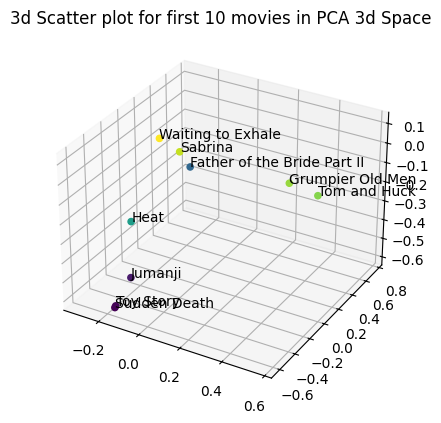

In [345]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


plt.figure()
ax = plt.axes(projection ='3d')

z
x
y

ax.scatter(x, y, z, c=z, alpha=1)

for x, y, z, label in zip(x, y, z, movies_title_list):
    ax.text(x, y, z, label)

# syntax for plotting
ax.set_title('3d Scatter plot for first 10 movies in PCA 3d Space')
plt.show()

In [326]:
# Ignore following code of block
# ROUGH WORK for future usage incase needed
# a3 = []
# for i in doc_lda:
#     a3.append(i)
# print(a3)
# print(len(a3),len(a3[1]))

# a1=[]
# rows, cols=len(doc_lda),num_topics
# for i in range(rows):
#     col = []
#     for j in range(cols):
#         col.append(0)
#     a1.append(col)
# print(a1)


# print('a3 :',a3)
# print('a1 :',a1)

# for i in range(len(a3)):
#     for j in range(len(a3[i])):
#             temp1 = a3[i][j][0]
#             temp2 = a3[i][j][1]
#             # print(temp1, temp2)
#             # print(a1[i][temp1])
#             # print(i,temp1)
#             a1[i][temp1] = temp2

# print('a1 :',a1)
# a1_ndarray = np.array(a1)
# print(a1_ndarray)